In [1]:
import pandas as pd
import matplotlib.pyplot as plt
print("W kontekście naszego zadania interesują nas pliki sessions.json i products.json")
print("Deliveries.json nie dotyczy naszego zadania, natomiast users.json ma poprawne rekordy")

W kontekście naszego zadania interesują nas pliki sessions.json i products.json
Deliveries.json nie dotyczy naszego zadania, natomiast users.json ma poprawne rekordy


In [2]:
MAX_PRICE = 1000000
products = pd.read_json("data/products.jsonl", lines=True)
print(f"Przed czyszczeniem: {products.shape[0]} produktów")
products.loc[products["price"] < 0, "price"] *= -1 # niektóre produkty mają ujemną cenę
products = products[products["price"] < MAX_PRICE] # niektóre produkty mają nieprawdopodobnie wysoką cenę, powyżej miliona
products["category_path"] = products["category_path"].str.rsplit(';', n=1, expand=True)[1] # skracamy ścieżkę kategorii
products.rename(columns={"category_path": "category"}, inplace=True)
products.to_json("data/products_clean.jsonl", orient='records', lines=True)
print(f"Po czyszczeniu: {products.shape[0]} produktów")


Przed czyszczeniem: 319 produktów
Po czyszczeniu: 308 produktów


In [3]:
sessions = pd.read_json("data/sessions.jsonl", lines=True)
products = pd.read_json("data/products_clean.jsonl", lines=True)
bought = sessions[sessions["event_type"] == "BUY_PRODUCT"]
bought_before = bought.shape[0]
print(f"Przed czyszczeniem: {sessions.shape[0]} sesji")
print("Najpierw uzupełniamy wartości nullowe klucza product_id w zdarzeniach zakupu")
print("Przed zakupem produktu najpierw klient ogląda produkt, można więc uzupełnić product_id wartością zdarzenia powyżej")
print("Gdybyśmy usuwali rekordy z wartościami nullowymi w zdarzeniach zakupu 176 sesji, które zakończyły się powodzeniem, zostałoby niepoprawnie uznane za nieudane")
bought_unknown_product = (sessions["event_type"] == "BUY_PRODUCT") & (sessions["product_id"].isnull())
sessions_to_drop = sessions[bought_unknown_product.shift(-1).fillna(False)]
sessions_to_drop = sessions_to_drop[sessions_to_drop["product_id"].isnull()]
sessions = sessions[~sessions["session_id"].isin(sessions_to_drop["session_id"])]
bought_unknown_product = (sessions["event_type"] == "BUY_PRODUCT") & (sessions["product_id"].isnull())
filled_sessions = sessions[bought_unknown_product | bought_unknown_product.shift(-1).fillna(False)]["product_id"].fillna(method="ffill")
sessions.loc[filled_sessions.index, "product_id"] = filled_sessions
bought = sessions[sessions["event_type"] == "BUY_PRODUCT"]
bought_after = bought.shape[0]
print(f"Zostało usuniętych w całości {bought_after - bought_before} udanych sesji.")
# uzupełnione
sessions = sessions[sessions["product_id"].isin(products["product_id"])] # zostawiamy tylko wpisy o produktach które znamy

sessions = pd.merge(sessions, products[['product_id','category']],on='product_id', how='left') # dodajemy kolumnę z kategorią
sessions = sessions.fillna({"user_id": sessions.groupby("session_id")["user_id"].transform('median')}) # uzupełniamy nullowe user_id które możemy
sessions["user_id"].fillna(method="ffill", inplace=True) 
# uzupełniamy nullowe wartości zamiast wyrzucać te rekordy; metoda uzupełnienia wartością rekordu wyżej będzie w
# znakomitej większości uzupełniać poprawnie user_id; jedyna sytuacja brzegowa w której potencjalnie (p=0.5) się pomyli
# ma bardzo małe prawdopodobieństo wystąpienia, dotyczy zera lub pojedynczych rekordów i dodatkowo dotyczy tylko eventów
# VIEW_PRODUCT więc spokojnie można tak uzupełniać
print(f"Po czyszczeniu: {sessions.shape[0]} sesji")
sessions = sessions.astype({'user_id': 'Int64', 'product_id': 'int32', 'purchase_id': "Int64"}, errors='ignore')
sessions.to_json("data/sessions_clean.jsonl", orient='records', lines=True)

Przed czyszczeniem: 56883 sesji
Najpierw uzupełniamy wartości nullowe klucza product_id w zdarzeniach zakupu
Przed zakupem produktu najpierw klient ogląda produkt, można więc uzupełnić product_id wartością zdarzenia powyżej
Gdybyśmy usuwali rekordy z wartościami nullowymi w zdarzeniach zakupu 176 sesji, które zakończyły się powodzeniem, zostałoby niepoprawnie uznane za nieudane
Zostało usuniętych w całości -14 udanych sesji.
Po czyszczeniu: 53468 sesji


3103


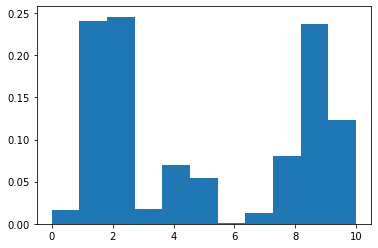

In [4]:
# pierwotnie próby analizy dotyczyły klasyfikowania niepewności klientów na podstawie ilości wyświeleń produktów w jednej sesji
# po konsultacjach porzuciliśmy tę ścieżkę, oto jedna z dziewięciu komórek w tej ścieżce :)
bought = sessions[sessions["event_type"] == "BUY_PRODUCT"]
print(bought.shape[0])
views = sessions[sessions["event_type"] == "VIEW_PRODUCT"]
successful_sessions = sessions[sessions["session_id"].isin(bought["session_id"])]
unsuccessful_sessions = sessions[~sessions["session_id"].isin(bought["session_id"])]
successful_views_count = successful_sessions.groupby("session_id")["user_id"].agg('count') - 1
unsuccessful_views_count = unsuccessful_sessions.groupby("session_id")["user_id"].agg('count')

plt.figure()
_ = plt.hist(successful_views_count.values, density=True, bins=11)
plt.show()
# widać nieregularny rozkład długości trwania sesji, który dalej udało nam się również wyjaśnić

In [5]:
bought_with_discount = bought[bought["offered_discount"] != 0]
successful_sessions_with_discount = sessions[sessions["session_id"].isin(bought_with_discount["session_id"])]
sessions_without_discount = sessions[sessions["offered_discount"] == 0]
sessions_with_discount = sessions[sessions["offered_discount"] != 0]
successful_sessions_without_discount = sessions_without_discount[sessions_without_discount["session_id"].isin(bought["session_id"])]
percentage_successful_with_discount =  successful_sessions_with_discount.shape[0] / sessions_with_discount.shape[0] * 100
percentage_successful_without_discount = successful_sessions_without_discount.shape[0] / sessions_without_discount.shape[0] * 100
print(f"Procent sukcesów ze zniżką: {percentage_successful_with_discount:.2f}")
print(f"Procent sukcesów bez zniżki: {percentage_successful_without_discount:.2f}")
print("Widzimy, że zniżka trochę działa")


Procent sukcesów ze zniżką: 35.00
Procent sukcesów bez zniżki: 34.27
Widzimy, że zniżka trochę działa


In [6]:
import numpy as np
for i in np.arange(0,21,5):
    bought_with_discount_i = bought[bought["offered_discount"] == i]
    sessions_with_discount_i = sessions[sessions["offered_discount"] == i]
    successful_sessions_with_discount_i = sessions[sessions["session_id"].isin(bought_with_discount_i["session_id"])]
    percentage_successful_with_discount_i = successful_sessions_with_discount_i.shape[0] / sessions_with_discount_i.shape[0] * 100
    print(f"Procent sukcesów ze zniżką {i}-procentową: {percentage_successful_with_discount_i:.2f}")
    
print("Istotna jest również wysokość zniżki")    

Procent sukcesów ze zniżką 0-procentową: 34.27
Procent sukcesów ze zniżką 5-procentową: 32.10
Procent sukcesów ze zniżką 10-procentową: 36.46
Procent sukcesów ze zniżką 15-procentową: 36.54
Procent sukcesów ze zniżką 20-procentową: 34.90
Istotna jest również wysokość zniżki


187
187


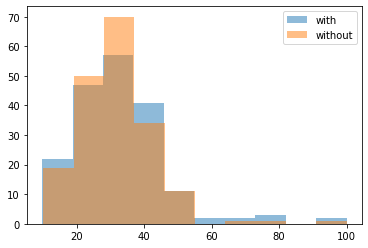

Histogram procentowy udanych sesji bez zniżek i ze zniżką
Wnioskujemy, że klienci są skłonni do dokonywania zakupów z różną częstotliwością i będzie możliwe na podstawie       historii zakupów estymować szansę na zakończenie sesji zakupem
Zauważalny jest także pozytywny wpływ zniżki na częstotliwość zakupów u części klientów - tego dotyczy nasze zadanie


In [7]:
successful_sessions_without_discount_by_user = successful_sessions_without_discount.groupby("user_id")["session_id"].nunique()
successful_sessions_with_discount_by_user = successful_sessions_with_discount.groupby("user_id")["session_id"].nunique()
sessions_with_discount_only_valid_users = sessions_with_discount[sessions_with_discount["user_id"].isin(successful_sessions_with_discount["user_id"])]
sessions_without_discount_only_valid_users = sessions_without_discount[sessions_without_discount["user_id"].isin(successful_sessions_without_discount["user_id"])]
sessions_without_discount_by_user = sessions_without_discount_only_valid_users.groupby("user_id")["session_id"].nunique()
sessions_with_discount_by_user = sessions_with_discount_only_valid_users.groupby("user_id")["session_id"].nunique()

print(len(successful_sessions_without_discount_by_user.values))
print(len(sessions_without_discount_by_user.values))
percentage_successful_sessions_without_discount_by_user = successful_sessions_without_discount_by_user / (sessions_without_discount_by_user) * 100
percentage_successful_sessions_with_discount_by_user = successful_sessions_with_discount_by_user / (sessions_with_discount_by_user) * 100


plt.figure()
_ = plt.hist(percentage_successful_sessions_with_discount_by_user, alpha=0.5, label='with')
_ = plt.hist(percentage_successful_sessions_without_discount_by_user, alpha=0.5, label='without')
plt.legend(loc='upper right')
plt.show()
print("Histogram procentowy udanych sesji bez zniżek i ze zniżką")
print("Wnioskujemy, że klienci są skłonni do dokonywania zakupów z różną częstotliwością i będzie możliwe na podstawie \
      historii zakupów estymować szansę na zakończenie sesji zakupem")
print("Zauważalny jest także pozytywny wpływ zniżki na częstotliwość zakupów u części klientów - tego dotyczy nasze zadanie")


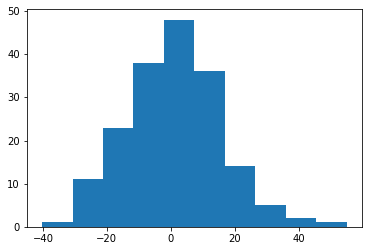

Histogram różnicy pomiędzy częstotliwością zakupów ze zniżką i bez zniżki w punktach procentowych    względem każdego użytkownika
Wygląda na to, że wpływ zniżki na zachowania użytkowników jest generowany z rozkładem normalnym
Zakładamy że uda się na podstawie tych danych estymować ów wpływ


In [8]:
difference = percentage_successful_sessions_with_discount_by_user - percentage_successful_sessions_without_discount_by_user
difference.dropna(inplace=True)
plt.figure()
_ = plt.hist(difference)
plt.show()
print("Histogram różnicy pomiędzy częstotliwością zakupów ze zniżką i bez zniżki w punktach procentowych\
    względem każdego użytkownika")
print("Wygląda na to, że wpływ zniżki na zachowania użytkowników jest generowany z rozkładem normalnym")
print("Zakładamy że uda się na podstawie tych danych estymować ów wpływ")

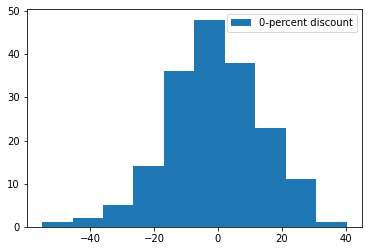

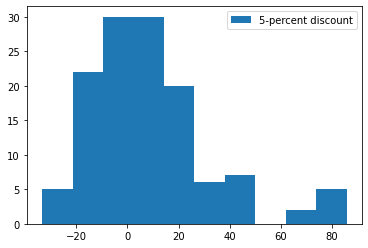

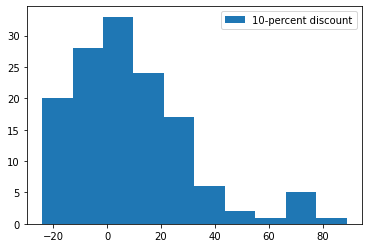

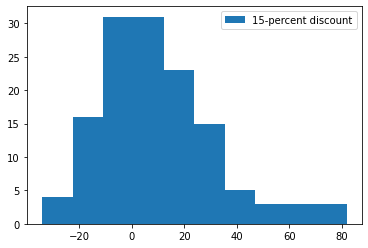

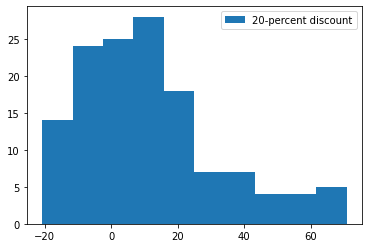

Histogramy przedstawiające różnicę w częstotliwości zakupów z i bez danej zniżki
Istotnie dla każdej wartości zniżki wpływ zniżki ma nieco inny rozkład
Im wyższa zniżka tym bardziej i częściej zauważalny jest pozytywny jej wpływ na zachowania klientów


In [9]:
for i in np.arange(0,21,5):
    
    sessions_with_discount_i = sessions[sessions["offered_discount"] == i]
    successful_sessions_with_discount_i = sessions_with_discount_i[sessions_with_discount_i["session_id"].isin(bought["session_id"])]
    successful_sessions_with_discount_i_by_user = successful_sessions_with_discount_i.groupby("user_id")["session_id"].nunique()
    sessions_with_discount_i_only_valid_users = sessions_with_discount_i[sessions_with_discount_i["user_id"].isin(successful_sessions_with_discount_i["user_id"])]
    sessions_with_discount_i_by_user = sessions_with_discount_i_only_valid_users.groupby("user_id")["session_id"].nunique()

    sessions_without_discount_i = sessions[~sessions["session_id"].isin(sessions_with_discount_i["session_id"])]
    sessions_without_discount_i_by_user = sessions_without_discount_i.groupby("user_id")["session_id"].nunique()
    successful_sessions_without_discount_i = sessions_without_discount_i[sessions_without_discount_i["session_id"].isin(bought["session_id"])]
    successful_sessions_without_discount_i_by_user = successful_sessions_without_discount_i.groupby("user_id")["session_id"].nunique()
    
    percentage_successful_sessions_with_discount_i_by_user = successful_sessions_with_discount_i_by_user / (sessions_with_discount_i_by_user) * 100
    percentage_successful_sessions_without_discount_i_by_user = successful_sessions_without_discount_i_by_user / (sessions_without_discount_i_by_user) * 100
    difference_i = percentage_successful_sessions_with_discount_i_by_user - percentage_successful_sessions_without_discount_i_by_user
    difference_i.dropna(inplace=True)
    plt.figure()
    _ = plt.hist(difference_i, label=f"{i}-percent discount")
    plt.legend()
    plt.show()

print("Histogramy przedstawiające różnicę w częstotliwości zakupów z i bez danej zniżki")    
print("Istotnie dla każdej wartości zniżki wpływ zniżki ma nieco inny rozkład")
print("Im wyższa zniżka tym bardziej i częściej zauważalny jest pozytywny jej wpływ na zachowania klientów")

In [10]:
bought_by_user_id = bought.groupby("user_id")["product_id"].agg("count")
bought_by_user_id_unique = bought.groupby("user_id")["product_id"].nunique()

print(f" Tyle zakupów dokonali klienci: {sum(bought_by_user_id.values)}")
print(f" Suma zakupów różnych produktów dla wszystkich klientów: {sum(bought_by_user_id_unique.values)}")

print("Klienci kupują te same produkty i to często")

 Tyle zakupów dokonali klienci: 3103
 Suma zakupów różnych produktów dla wszystkich klientów: 1748
Klienci kupują te same produkty i to często


In [11]:
bought_by_user_category = bought.groupby("user_id")["category"].agg("count")
bought_by_user_category_ = bought.groupby("user_id")["category"].nunique()

print(f" Tyle zakupów dokonali klienci: {sum(bought_by_user_category.values)}")
print(f" Suma zakupów różnych kategorii dla wszystkich klientów: {sum(bought_by_user_category_.values)}")
print("Zdziwiła nas ta sama suma względem kategorii co względem produktów")

 Tyle zakupów dokonali klienci: 3103
 Suma zakupów różnych kategorii dla wszystkich klientów: 1748
Zdziwiła nas ta sama suma względem kategorii co względem produktów


In [12]:
print(bought_by_user_id_unique.values == bought_by_user_category_.values)
print("Oznacza to, że klient zawsze kupuje ten sam produkt z danej kategorii - nieco dziwne :)")

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [13]:
bought_by_category = bought.groupby("category")["session_id"].agg("count")
bought_by_category_ = bought.groupby("category")["session_id"].nunique()
print(bought_by_category)
print(bought_by_category_)
print(sum(bought_by_category.values))
print(sum(bought_by_category_.values))
print("Tutaj jeszcze jedno potwierdzenie wniosków z poprzedniej komórki")
print("Widać też że ilość sesji (tym samym zakupów) dla danej kategorii produktów jest generowana z\
rozkładem jednostajnym (domyślamy się, że \"na rozpoczęciu sesji\" po prostu jest losowana kategoria produktów,\
które będzie oglądać klient)")


category
Anteny RTV                           195
Biurowe urządzenia wielofunkcyjne    212
Gry PlayStation3                     219
Gry Xbox 360                         210
Gry komputerowe                      228
Monitory LCD                         223
Odtwarzacze DVD                      193
Odtwarzacze mp3 i mp4                173
Okulary 3D                           221
Słuchawki                            191
Tablety                              215
Telefony komórkowe                   200
Telefony stacjonarne                 223
Zestawy głośnomówiące                194
Zestawy słuchawkowe                  206
Name: session_id, dtype: int64
category
Anteny RTV                           195
Biurowe urządzenia wielofunkcyjne    212
Gry PlayStation3                     219
Gry Xbox 360                         210
Gry komputerowe                      228
Monitory LCD                         223
Odtwarzacze DVD                      193
Odtwarzacze mp3 i mp4                173
Okulary 

In [14]:
users = pd.read_json("data/users.jsonl", lines=True)
products = pd.read_json("data/products_clean.jsonl", lines=True)
products_categories_count = products.groupby("category")["product_id"].agg('count')
print(products_categories_count)

print("Ilość sesji dla każdej kategorii jest podobna mimo, że ilość produktów w danej kategorii jest znacznie różna ")
print("Tym samym, a także obserwacji, że klient w jednej sesji ogląda produkty tylko jednej kategorii\
    wyjaśniliśmy rozkład długości trwania sesji z komórki [4] - gdy wylosowana jest dla sesji kategoria o liczności produktów\
    mniejszej od 10, klient przegląda w sesji wszystkie produkty danej kategorii")
print("Istotny jest również fakt, że zawsze schemat sesji dla wszystkich klientów jest taki sam")
print("Wszyscy klienci zawsze przeglądają produkty w rosnącym porządku względem product_id")
print("Kolejnym wynikającym z tego faktem jest to, że zawsze jest kupowany ten sam produkt z danej kategorii")
print("Jeśli model, który będziemy tworzyć miałby działać w środowisku z klientami zachowującymi się w taki sam sposób\
    bezsensowne byłoby rozpatrywanie jakichkolwiek produktów poza tymi o największym product_id w danej kategorii (dla kategorii\
    o wielu produktach, czyli >10, klienci kupują ten o najwyższym product_id spośród oglądanych, a oglądają 10 produktów\
    o najniższym product_id), bo\
    inne i tak nie są nigdy kupowane")
print(f"Wobec tych wniosków niepotrzebne okazało się oczyszczanie produktów z [1]-ej komórki, bo interesuje nas tylko\
    {len(products_categories_count)} produktów (liczba kategorii).")

category
Anteny RTV                            29
Biurowe urządzenia wielofunkcyjne      9
Gry PlayStation3                       9
Gry Xbox 360                          32
Gry komputerowe                      192
Monitory LCD                          17
Odtwarzacze DVD                        2
Odtwarzacze mp3 i mp4                  2
Okulary 3D                             1
Słuchawki                              1
Tablety                                2
Telefony komórkowe                     2
Telefony stacjonarne                   1
Zestawy głośnomówiące                  5
Zestawy słuchawkowe                    4
Name: product_id, dtype: int64
Ilość sesji dla każdej kategorii jest podobna mimo, że ilość produktów w danej kategorii jest znacznie różna 
Tym samym, a także obserwacji, że klient w jednej sesji ogląda produkty tylko jednej kategorii    wyjaśniliśmy rozkład długości trwania sesji z komórki [4] - gdy wylosowana jest dla sesji kategoria o liczności produktów    mniejszej od

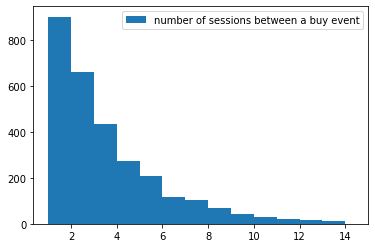

In [54]:
## odległość czasowa w timestampach lub sesja
intervals = []
for user in bought.groupby("user_id"):
    li = user[1]["session_id"].values
    for i in range(1, len(li)):
        intervals.append(li[i] - li[i-1])
plt.figure()
_ = plt.hist(intervals, label=f"number of sessions between a buy event", bins=range(1, 15, 1))
plt.legend()
plt.xlim(xmax = 15)
plt.show()
        

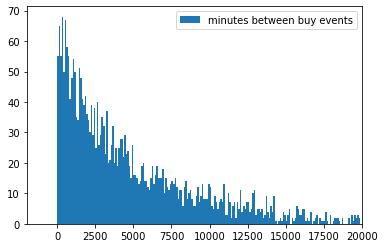

In [55]:

intervals = []
for user in bought.sort_values(['user_id','timestamp']).groupby("user_id"):
    li = user[1]["timestamp"].values
    for i in range(1, len(li)):
        intervals.append(int((li[i] - li[i-1]) / np.timedelta64(1, 'm')))

plt.figure()
_ = plt.hist(intervals, label=f"minutes between buy events", bins=range(0, 40000, 100))
plt.legend()
plt.xlim(xmax = 20000)
plt.show()
        

In [ ]:
# odległość czasowa to nie będzie dobry atrybut, szczególnie w timestampach; 
# własność braku pamięci najwyraźniej zachowana

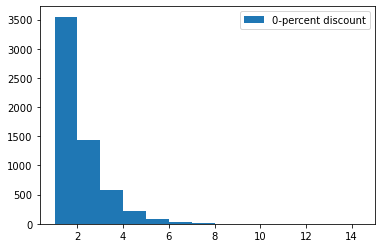

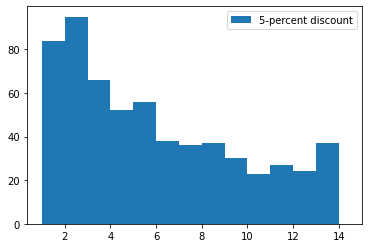

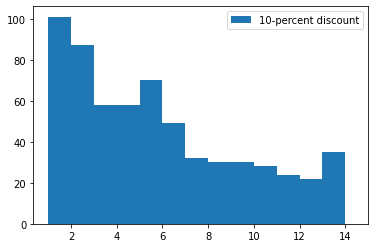

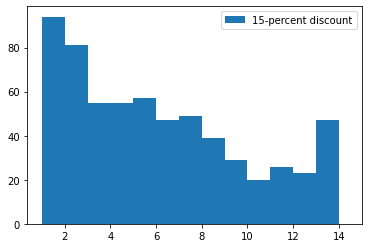

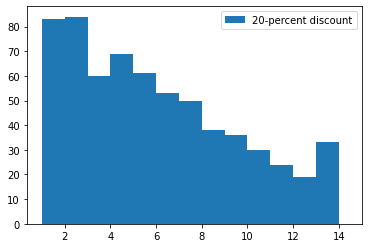

In [57]:
# for i in np.arange(0,21,5):
#     intervals = []
#     sessions_with_discount_i = sessions[sessions["offered_discount"] == i]
#     successful_sessions_with_discount_i = sessions_with_discount_i[sessions_with_discount_i["session_id"].isin(bought["session_id"])]
#     successful_sessions_with_discount_i_by_user = successful_sessions_with_discount_i.groupby("user_id")["session_id"].nunique()
#     sessions_with_discount_i_only_valid_users = sessions_with_discount_i[sessions_with_discount_i["user_id"].isin(successful_sessions_with_discount_i["user_id"])]
#     for user in sessions_with_discount_i_only_valid_users.groupby("user_id"):
#         li = user[1]["session_id"].values
#         for j in range(1, len(li)):
#             intervals.append(li[j] - li[j-1])

#     plt.figure()
#     _ = plt.hist(intervals, label=f"{i}-percent discount", bins=range(1, 15, 1))
#     plt.legend()
#     plt.xlim(xmax = 15)
#     plt.show()